In [1]:
import findspark
findspark.init()
import pyspark

In [2]:
import datetime
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.types import *

In [3]:
spark = SparkSession.builder.getOrCreate()
%matplotlib inline

# Worldwide ratio by day

In [4]:
DATA_FOLDER = "./"

In [10]:
countries = pd.read_csv(DATA_FOLDER+"countries.csv")[["ISO", "Country", "Region"]]
countries.ISO = countries.ISO.str.upper()
countries.set_index("ISO", inplace=True)

regions = countries.Region.unique()[:-1]
print("Regions list:", regions)

fips_to_iso = pd.read_csv(DATA_FOLDER+"fips-10-4-to-iso-country-codes.csv")
countries = countries.merge(fips_to_iso, how="left", left_index=True, right_on="ISO")
countries.drop(columns=["Name"], inplace=True)
countries.dropna()

countries.head(10)


Regions list: ['Asia' 'Europe' 'Africa' 'Oceania' 'Americas']


,Country,Region,FIPS,ISO
0,Afghanistan,Asia,AF,AF
278,Aland Islands,Europe,NaN,AX
2,Albania,Europe,AL,AL
3,Algeria,Africa,AG,DZ
4,American Samoa,Oceania,AQ,AS
5,Andorra,Europe,AN,AD
6,Angola,Africa,AO,AO
7,Anguilla,Americas,AV,AI
8,Antarctica,NaN,AY,AQ
9,Antigua and Barbuda,Americas,AC,AG


In [11]:
countries.to_csv("preprocessed_countries.csv")

In [8]:
counts_file = DATA_FOLDER+"mentions_counts_by_state_and_day_DOMAIN.csv"

In [21]:
def read_csv(path, states=None):
    counts = pd.read_csv(path)
    counts = counts.merge(countries[["Country", "ISO", "FIPS", "Region"]], how="inner", left_on="STATE", right_on="FIPS")
    counts.dropna(inplace=True)
    counts = counts.assign(DATE=pd.to_datetime(counts[["YEAR", "MONTH", "DAY"]]))
    if states is not None:
        counts = counts[counts.STATE.isin(states)]

    counts.drop(columns=["FIPS", "YEAR", "MONTH", "DAY"], inplace=True)
    counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
    counts = counts[["DATE", "STATE", "ISO", "Country", "Region", "GLOBAL_COUNT", "ENV_COUNT", "Ratio"]]
    return counts

In [15]:
counts = read_csv(counts_file)
counts = counts.groupby(["DATE"]).sum()
counts = counts.reset_index()
counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
counts.describe()

,GLOBAL_COUNT,ENV_COUNT,Ratio
count,1.010000e+03,1010.000000,1010.000000
mean,6.531005e+05,156629.846535,0.241217
std,1.648983e+05,47451.398088,0.046972
min,3.677700e+04,10129.000000,0.136444
25%,5.158420e+05,123274.750000,0.210629
50%,6.864290e+05,156899.000000,0.233717
75%,7.705880e+05,183369.500000,0.263205
max,1.343483e+06,371550.000000,0.536906


Text(0, 0.5, 'Ratio')

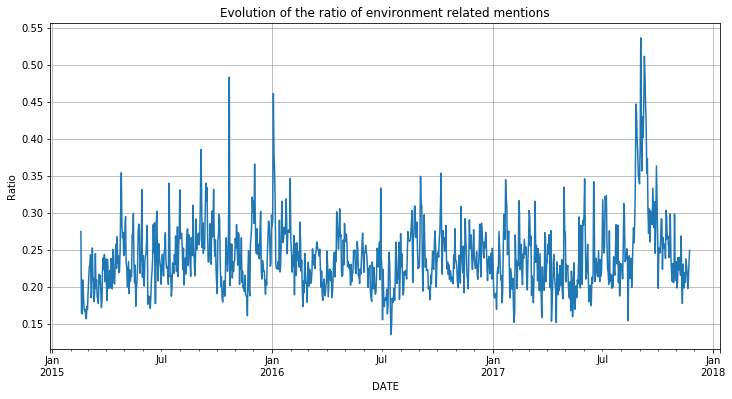

In [16]:
ax = counts.plot.line(x="DATE", y=["Ratio"], figsize=(12, 6), legend=None, grid=True,
                 title="Evolution of the ratio of environment related mentions")
ax.set_ylabel("Ratio")

In [17]:
counts[counts.Ratio>0.47].sort_values("Ratio", ascending=False)

,DATE,GLOBAL_COUNT,ENV_COUNT,Ratio
928,2017-09-03,447799,240426.0,0.536906
934,2017-09-09,401637,205712.0,0.512184
935,2017-09-10,378243,184481.0,0.487731
246,2015-10-22,61835,29923.0,0.483917


# Ratio by european countries

In [18]:
counts = read_csv(counts_file, countries[countries.Region=="Europe"].FIPS.values)
counts.describe()

,GLOBAL_COUNT,ENV_COUNT,Ratio
count,32397.000000,32397.000000,32397.000000
mean,1663.548137,360.670741,0.245851
std,6328.158260,1230.630122,0.200964
min,1.000000,1.000000,0.001167
25%,65.000000,9.000000,0.105820
50%,192.000000,33.000000,0.188571
75%,562.000000,116.000000,0.324168
max,70445.000000,22991.000000,1.000000


In [22]:
europe_counts = counts.groupby(["ISO", "Country"]).sum()
europe_counts = europe_counts.assign(Ratio=europe_counts.ENV_COUNT/europe_counts.GLOBAL_COUNT)
europe_counts.sort_values("GLOBAL_COUNT", ascending=False).head(20)

,,GLOBAL_COUNT,ENV_COUNT,Ratio
ISO,Country,,,
GB,United Kingdom of Great Britain and Northern Ireland,34737136,5721173.0,0.164699
RU,Russian Federation,6015843,3352470.0,0.557274
IE,Ireland,4093624,568979.0,0.138992
DE,Germany,1238267,313245.0,0.252970
FR,France,945213,232049.0,0.245499
IT,Italy,877931,197223.0,0.224645
CH,Switzerland,659607,193641.0,0.293570
GR,Greece,621755,138977.0,0.223524
BG,Bulgaria,586876,102351.0,0.174400
